In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# データを読み込む

In [2]:
# シンプルデータセット１作成コード
# 特徴量2つのデータセット
import numpy as np

np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X_1 = np.concatenate((f0, f1))
y_1 = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X_1 = X_1[random_index]
y_1 = y_1[random_index]

In [3]:
#Y_1 を2次元に変換
y_1 = y_1[:, np.newaxis]

In [4]:
#Xとｙを連結　　　df.query('state == "CA"'))
X_y = np.concatenate([X_1, y_1], axis=1)

#X_yをDF化
df = pd.DataFrame(X_y)

# display(df.head())
#ラベルを1、－１に分ける
df_1 = df[df[2]==1]
df_2 = df[df[2]== -1]

# display(df_1.head())
# display(df_2.head())

In [5]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1,train_size=0.75)

C:\Users\ykenk\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# クラス作成

In [6]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル
    self.val_lam : 次の形のndarray, shape (self.iter,)
      検証用データに対する学習の記録
    self.  
    """

    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter #学習回数
        self.lr = lr # 学習率
        self.kernel = kernel # カーネルの種類
        self.threshold = threshold # 閾値
        self.verbose = verbose # 学習過程を出力するか否か
        
        # 学習を記録する配列を用意
        #self.loss = np.zeros(self.iter)
        self.val_lam = np.zeros(self.iter)


    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証用データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        # サンプル数分のラグランジュ乗数を初期化
        self.lam = np.zeros(X.shape[0])
        self.val_lam = np.zeros(X.shape[0])
        
        #学習回数のカウンター
        count = 0
        
        # 学習
        for i in range(self.iter):
            self.lam = self.lam + self._gradient_descent(X, y)
            
            #検証用データ有り
            if X_val is not None and y_val is not None:
                # 学習記録
                self.val_lam = self.val_lam + self._gradient_descent(X_val, y_val)
                
                # 検証用データが入力された場合はそれに対する精度もイテレーションごとに計算する
                
            #verboseをTrueにした際は学習過程を出力
            if self.verbose == True:
                count += 1
                print("{}回目の学習記録は{}".format(count, self.lam))
                #検証用データがある場合
                if X_val is not None and y_val is not None:
                    print("{}回目の学習記録は{}".format(count, self.val_lam))
                    
        
        #サポートベクター : ndarray
        #self.support_vectors = self.lam[self.lam > self.threshold]
        
        #サポートベクターの数 : int 
        self.n_support_vectors = len(self.lam[self.lam > self.threshold])
        
        #サポートベクターのインデックス
        #次の形のndarray, shape (n_support_vectors,)
        self.index_support_vectors = np.where(self.lam > self.threshold)[0]
        
        #サポートベクターの特徴量
        #次の形のndarray, shape(n_support_vectors, n_features)
        self.X_sv = X[self.index_support_vectors, :]
        
        #サポートベクターの未定乗数
        #次の形のndarray, shape(n_support_vectors, 1)
        self.lam_sv = self.lam[self.lam > self.threshold].reshape(-1, 1)
        
        #サポートベクターのラベル
        # 次の形のndarray, shape(n_support_vectors, 1)
        self.y_sv = y[self.index_support_vectors]
      
        
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        #for h in range(X.shape[0]):
        #    k(X, self.X_sv)
            
        y_pred =  self._kernel(X, self.X_sv) @ (self.lam_sv * self.y_sv)
        y_pred = np.where(y_pred>=0, 1, -1)
            
        return y_pred
    
    
    #kernel関数を定義
    def _kernel(self, Xi, Xj):
       
        return np.dot(Xi, Xj.T)
    
    #最急降下法を定義
    def _gradient_descent(self, X, y):
        """
        最急降下法を行う。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ
        y : 次の形のndarray, shape (n_samples, 1)
          正解値
        """
        
        #更新される前のlamをコピーしておく
        lam_copy = self.lam.copy()
        #カーネル関数を定義しておく
        k = self._kernel(X, X)
        
        for i in range(X.shape[0]):
            #初期化
            delta = 0
            #deltaを更新して行く
            for j in range(X.shape[0]):
                delta += self.lam[j] * y[i] * y[j] * k[i, j]
            self.lam[i] += self.lr * (1 - delta)
            
            #更新されたlamが0より小さい場合lam=0とする
            if self.lam[i] < 0:
                self.lam[i] = 0
         
        return self.lam

# 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 
λ
 を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。

## 上記

# 【問題2】サポートベクターの決定
計算したラグランジュ乗数 
λ
 が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。

閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

## 上記

# 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた 
f
(
x
)
 の符号が分類結果です。

## 上記

# 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

## 学習・推定

## Scratch

In [7]:
ssvmc_0 = ScratchSVMClassifier(num_iter=50, lr=0.001, kernel='linear', threshold=1e-2, verbose=False)
ssvmc_0.fit(X_train, y_train)
ssvmc_pred = ssvmc_0.predict(X_test)

print("推定は\n{}".format(ssvmc_pred.flatten()))

推定は
[-1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1
 -1  1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1  1 -1 -1  1  1 -1  1 -1 -1
 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1 -1 -1 -1  1 -1  1  1 -1 -1  1  1  1
  1 -1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1
  1 -1  1  1  1 -1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1
  1  1  1  1 -1]


In [8]:
print("サポートベクター数 : {}".format(ssvmc_0.n_support_vectors))

サポートベクター数 : 11


## 検証用データなし・出力あり

In [9]:
ssvmc = ScratchSVMClassifier(num_iter=10, lr=0.01, kernel='linear', threshold=1e-2, verbose=True)
ssvmc.fit(X_train, y_train)

1回目の学習記録は[2.00000000e-02 1.92016158e-02 1.66785107e-02 1.65926792e-02
 1.57679678e-02 1.65033618e-02 1.41045860e-02 1.36999910e-02
 1.64008936e-02 1.19000878e-02 1.59418315e-02 1.42667047e-02
 9.93974253e-03 9.15600367e-03 1.11844442e-02 1.07269834e-02
 9.80562948e-03 1.17382208e-02 7.64453601e-03 8.86392825e-03
 6.31498127e-03 6.99384922e-03 1.18527901e-02 5.84766760e-03
 6.84307833e-03 6.42396305e-03 3.11577842e-03 5.63793805e-03
 3.76934379e-03 6.47926790e-03 1.80041050e-03 0.00000000e+00
 8.27137404e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.03486708e-03 3.10105667e-03 4.81536558e-03 5.14718357e-03
 4.83575058e-04 3.50329594e-03 6.07388345e-03 0.00000000e+00
 4.04575474e-03 3.61853138e-03 3.50413782e-03 0.00000000e+00
 9.89670798e-03 6.48846913e-03 2.41386572e-03 3.52886773e-03
 0.00000000e+00 7.61865336e-04 6.23496533e-03 0.00000000e+00
 1.90654812e-03 1.27271169e-03 1.11199593e-03 2.33006796e-03
 1.51477830e-03 1.29308341e-03 1.69230516e-03 4.64555221e-03
 2.76903881e-03

3回目の学習記録は[0.03858471 0.         0.         0.         0.         0.0273864
 0.         0.         0.01897086 0.         0.         0.02767342
 0.         0.         0.         0.         0.         0.01871587
 0.         0.         0.         0.         0.02446296 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01400478 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.03522876 0.01169274 0.         0.         0.         0.
 0.00716279 0.         0.         0.         0.         0.
 0.         0.         0.         0.00219728 0.         0.00128164
 0.00318149 0.         0.         0.         0.00619326 0.03240348
 0.         0.         0.00728042 0.         0.03032434 0.
 0.         0.         0.0195825  0.03058181 0.         0.
 0.         0.         0.         0.02048375 0.         0.04796219
 0.         0.         0.         0.         0.03082043 0.


6回目の学習記録は[9.55217631e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.81733323e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00

8回目の学習記録は[0.03788564 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0668027  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.89505383
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.   

## 検証用データ有り・出力あり

In [10]:
ssvmc_1 = ScratchSVMClassifier(num_iter=10, lr=0.01, kernel='linear', threshold=1e-2, verbose=True)
ssvmc_1.fit(X_train, y_train, X_test, y_test)

1回目の学習記録は[0.00000000e+00 1.52507667e-03 0.00000000e+00 0.00000000e+00
 7.25280523e-03 1.36170210e-03 2.51125620e-03 2.96126170e-04
 5.99869329e-03 2.70556876e-03 1.09523894e-02 5.05379475e-03
 1.70452295e-03 7.22758448e-03 8.44674495e-03 1.81613361e-03
 1.15882104e-02 6.43775195e-03 0.00000000e+00 4.11106697e-04
 0.00000000e+00 5.34366465e-03 8.84593432e-03 8.64793029e-03
 7.18170809e-04 3.03014699e-03 0.00000000e+00 2.93265224e-03
 0.00000000e+00 0.00000000e+00 5.22546228e-04 0.00000000e+00
 4.36822443e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.20873602e-03 0.00000000e+00 3.15114783e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.12869105e-03 2.55520898e-03 0.00000000e+00
 4.99311529e-03 5.07764899e-03 2.35380154e-03 0.00000000e+00
 1.11871726e-03 0.00000000e+00 4.50176032e-03 1.71808584e-03
 0.00000000e+00 6.13834174e-04 0.00000000e+00 2.08117367e-03
 0.00000000e+00 0.00000000e+00 6.72628215e-04 3.62392732e-03
 6.12078950e-03

2回目の学習記録は[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00873048 0.00206441
 0.         0.00015165 0.01094015 0.         0.01887189 0.00706608
 0.         0.         0.         0.         0.01366551 0.01192924
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00307107 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00022677 0.         0.
 0.00378996 0.00691061 0.         0.         0.         0.
 0.00189192 0.         0.         0.         0.         0.
 0.         0.         0.         0.00182689 0.01103405 0.
 0.00681943 0.         0.         0.00342513 0.00238882 0.0235624
 0.         0.         0.01546772 0.         0.00755677 0.
 0.00832588 0.00142162 0.00378162 0.02627892 0.         0.
 0.00273049 0.         0.         0.00816028 0.         0.00995962
 0.         0.00352556 0.         0.00074343 0.01327638 0.01137079


3回目の学習記録は[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.38710752e-04 2.25889907e-03 0.00000000e+00
 2.02258412e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.71601086e-02 3.21820884e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.91292233e-03

4回目の学習記録は[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00550479 0.
 0.         0.         0.         0.         0.01128885 0.00238102
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00148718 0.
 0.         0.         0.         0.         0.         0.05730649
 0.         0.         0.00379832 0.         0.         0.
 0.00012976 0.         0.         0.08571573 0.         0.
 0.         0.         0.         0.         0.         0.01253475
 0.         0.         0.         0.         0.01293516 0.00762386
 0.03733996 0. 

5回目の学習記録は[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.99389972e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.57499037e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.63515557e-05

6回目の学習記録は[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.08382868
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.21952827 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.   

7回目の学習記録は[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.05193629
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.33862284 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.   

8回目の学習記録は[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.50345685 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

9回目の学習記録は[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.68838298 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

10回目の学習記録は[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.80519587 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0

In [11]:
# 5つの指標を出力する関数
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix

def index_5(predict_train, data_name): #predict_train=predict(X_test), data_name=file_name
    
    ind_5 = {"Accuracy" : [accuracy_score(y_test.flatten(), predict_train)*100],
            "Precision" : [precision_score(y_test.flatten(), predict_train)*100],
            "Recall" : [recall_score(y_test.flatten(), predict_train)*100],
            "F1" : [f1_score(y_test.flatten(), predict_train)],
            "ConfusionMatrix" : [confusion_matrix(y_test.flatten(), predict_train)]
            }
    index1 = [data_name]
    result = pd.DataFrame(data=ind_5, index=index1)
    
    return result

In [12]:
d = ssvmc_pred.flatten()
scr = index_5(d, 'Scratch')
display(scr)

,Accuracy,Precision,Recall,F1,ConfusionMatrix
Scratch,100.0,100.0,100.0,1.0,"[[62, 0], [0, 63]]"


## Sklearn

In [13]:
from sklearn.svm import SVC

clf_SVC = SVC(gamma='auto')
clf_SVC = clf_SVC.fit(X_train, y_train) # SVCに訓練データを学習させる
SVC_predict = clf_SVC.predict(X_test) # SVCによる検証データの分類

skl = index_5(SVC_predict, 'Sklearn')
display(skl)

C:\Users\ykenk\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Accuracy,Precision,Recall,F1,ConfusionMatrix
Sklearn,100.0,100.0,100.0,1.0,"[[62, 0], [0, 63]]"


## 分類精度・比較

In [14]:
pd.concat([scr, skl])

,Accuracy,Precision,Recall,F1,ConfusionMatrix
Scratch,100.0,100.0,100.0,1.0,"[[62, 0], [0, 63]]"
Sklearn,100.0,100.0,100.0,1.0,"[[62, 0], [0, 63]]"


# 【問題5】決定領域の可視化
決定領域を可視化してください。

以下の例のようにサポートベクターは異なる色で示してください。

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['1', '-1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step),
                                    np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap='viridis')
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
        
    plt.scatter(model.X_sv[:, 0], model.X_sv[:, 1], s=80, color='yellow' , marker='o', label="SupprtVector")
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

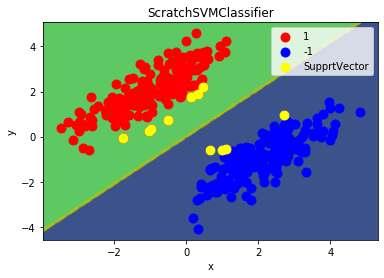

In [16]:
#訓練用
decision_region(X_train, y_train.flatten(), ssvmc_0, step=0.01, title='ScratchSVMClassifier', xlabel='x', ylabel='y')

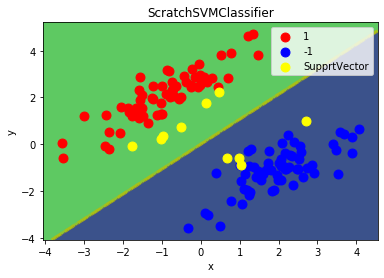

In [18]:
#検証用
decision_region(X_test, y_test.flatten(), ssvmc_1, step=0.01, title='ScratchSVMClassifier', xlabel='x', ylabel='y')